In [303]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import scipy.stats as stats
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Retrieving Data

The data was retrieved from Montgomery County's open data portal [here](https://data.montgomerycountymd.gov/widgets/he7s-ebwb?mobile_redirect=true). Specifically, I found the appropriate request using Firefox's network tool, loaded the request in Insomnia, changed the id limit parameter to load all of the data, and used Insomnia to create a query using Python's request library. The reseponse was, fortunately, a very nice JSON string.

In [304]:
url = "https://data.montgomerycountymd.gov/api/id/he7s-ebwb.json"

# There are 9958 employee records; this loads all of the data
querystring = {"$query":"select *, :id limit 9958"}

payload = ""
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:102.0) Gecko/20100101 Firefox/102.0",
    "Accept": "application/json",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",
    "Referer": "https://data.montgomerycountymd.gov/widgets/he7s-ebwb?mobile_redirect=true",
    "X-Socrata-Federation": "Honey Badger",
    "X-App-Token": "U29jcmF0YS0td2VraWNrYXNz0",
    "X-Requested-With": "XMLHttpRequest",
    "Connection": "keep-alive",
    "Cookie": "_frontend_session=RzFROVpuK1k5RXg0VVZhcEVXajBxdVVpVXJWd0pvWDY1eHBLVGlDNFYxc2IyRWV6ZC9aT3hsYUpFbnFQN1Z6NWdGN1VYVGFJelBWSVhRZ3FyK21wRS9kRlY3bWU1OXdmVHJwZWQ5dk13ZFNXNkdqeEpzL0M2NkhFcGkxazFHV3VCVjRLSDdNdU1QTGZMZldxYmtjUVd4bG1odys4KzBmajg4MjZBUFJDWnp2azZFNFpma1Q4OGFETGRuNmFTclVRWHBPc0NxZEtjT0JnVzlwYTF0dmVma2o3ZWl2ZWpwcUEyejJkd21RdkZZUzZTTGxsbFd5TklZTFdXKzRUOXNUMXdtVGt6SnQvcWxxMmlXQmtRN2sxd2cwTFVqZnlkaUFFMy81Nk5PMjZSNW89LS1xd1RkU1lETWZBNGNKck94Z0dTMnlBPT0%3D--53af52b516a73eef4406b1ddc4008746c6bbaf93; socrata-csrf-token=MtxwuKTHkI6lnTZl7si794H/vqDvP5rebyURkBWL/vQUfYQlt+5SVH9epGxtAu0g3ccsw5BN+A9sea+shuR/YA==; _ga=GA1.2.1923128069.1657561745; _gid=GA1.2.293823794.1657561745",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-origin"
}

response = requests.request("GET", url, data=payload, headers=headers, params=querystring)

data = response.json()

In [305]:
df = pd.json_normalize(data)
df.head()

,department,department_name,division,gender,base_salary,_2020_overtime_pay,_2020_longevity_pay,grade,:id
0,ABS,Alcohol Beverage Services,Wholesale Administration,F,78902.00,199.17,0.00,18,row-zsve-xuyu.q69s
1,ABS,Alcohol Beverage Services,Administrative Services,F,35926.00,0.00,4038.91,16,row-hc9h-u4a8-4sht
2,ABS,Alcohol Beverage Services,Administration,M,167345.00,0.00,0.00,M2,row-e39h_asgn~x33v
3,ABS,Alcohol Beverage Services,Wholesale Operations,F,90848.00,0.00,5717.68,21,row-w2w8~sazr~wn4e
4,ABS,Alcohol Beverage Services,Administration,F,78902.00,205.16,2460.24,18,row-iype~m3id-br4b


# Data Cleaning

The head of the dataframe looks nice, other than the :id feature and some of the column names. First I look at the :id feature, to determine if it contains values worth keeping. Next, I rename the columns.

In [306]:
id = list(set(row[':id'] for row in data))
print('First 20 unique :id values:')
id[:20]

First 20 unique :id values:


['row-phmf-nwmq.u9ve',
 'row-qws2_y9a6-6bsx',
 'row-b3rz.e5id_efxg',
 'row-sez8.33bq~2yuw',
 'row-9ayw~ke8d~zey2',
 'row-eh43.gksz~mrgg',
 'row-vhg5~t2xt_t6kx',
 'row-piyi-8bib~ndx9',
 'row-2bic.cyy3-79wr',
 'row-p5pt.pb7r.yj3c',
 'row-a67v-wbk6~tnae',
 'row-ef6h_6nn2~7ux2',
 'row-9w79~642h-33et',
 'row-g2yk-q4ij_3dzc',
 'row-kyxd-frdv.wm3v',
 'row-hwrn-i79e.8dv5',
 'row-5s9u-y88p_r2jt',
 'row-m84r.5k6b-inxa',
 'row-n99r-bjvr-q3me',
 'row-9gz2~npc2~vcwx']

It is safe to conclude that this does not contain any useful information about employee pay.

In [307]:
# Drop :id feature
df.drop(':id', axis=1, inplace=True)

df.columns = ['department', 'department_name', 'division', 'gender', 'base_salary',
       'overtime_pay', 'longevity_pay', 'pay_grade']

In [308]:
df.head()

,department,department_name,division,gender,base_salary,overtime_pay,longevity_pay,pay_grade
0,ABS,Alcohol Beverage Services,Wholesale Administration,F,78902.00,199.17,0.00,18
1,ABS,Alcohol Beverage Services,Administrative Services,F,35926.00,0.00,4038.91,16
2,ABS,Alcohol Beverage Services,Administration,M,167345.00,0.00,0.00,M2
3,ABS,Alcohol Beverage Services,Wholesale Operations,F,90848.00,0.00,5717.68,21
4,ABS,Alcohol Beverage Services,Administration,F,78902.00,205.16,2460.24,18


## Correct Datatypes

In [309]:
# Identify numerical and categorical features
numerical = ['base_salary', 'overtime_pay', 'longevity_pay', 'total_compensation', 'extra_pay']
categorical = [feat for feat in df.columns if feat not in numerical]

for feature in df.columns:
    # Convert numerical features to float
    if feature in numerical:
        df[feature] = df[feature].astype(np.float64)

## Check if department and department_name are redundant

In [310]:
# Compare number of unique values
print('Number of unique department values: ', df['department'].unique().shape[0])

print('Number of unique department_name values: ', df['department_name'].unique().shape[0])

Number of unique department values:  40
Number of unique department_name values:  40


The number of values is the same, suggesting the features are redundant. Pandas will list unique string features alphabetiically

In [311]:
for i, dept in enumerate(df['department'].unique()):
    dept_name = df['department_name'].unique()[i]
    print(f'{dept}: {dept_name}')

ABS: Alcohol Beverage Services
BOA: Board of Appeals Department
BOE: Board of Elections
CAT: County Attorney's Office
CCL: County Council
CEC: Community Engagement Cluster
CEX: Offices of the County Executive
COR: Correction and Rehabilitation
CUS: Community Use of Public Facilities
DEP: Department of Environmental Protection
DGS: Department of General Services
DHS: Office of Emergency Management and Homeland Security
DOT: Department of Transportation
DPS: Department of Permitting Services
DTS: Department of Technology Services
ECM: Ethics Commission
FIN: Department of Finance
FRS: Fire and Rescue Services
HCA: Department of Housing and Community Affairs
HHS: Department of Health and Human Services
HRC: Office of Human Rights
IGR: Office of Intergovernmental Relations Department
LIB: Department of Public Libraries
MPB: Merit System Protection Board Department
NDA: Non-Departmental Account
OAG: Office of Agriculture
OAS: Office of Animal Services
OCP: Office of Consumer Protection
OHR: 

Each abbreviation seems to correspond to the corresponding name. We can check to make sure that the same is true in the dataframe.

In [312]:
dept_mapper = {}
for i, dept in enumerate(df['department'].unique()):
    dept_name = df['department_name'].unique()[i]
    dept_mapper[dept] = dept_name

In [313]:
mapped_depts = df.replace({'department':dept_mapper})['department']
if (mapped_depts == df['department_name']).all:
    print('department and mapped_department are redundant.')
else:
    print('department and mapped_department are distinct.')

department and mapped_department are redundant.


The department and mapped_department features are not distinct.

# Exploratory Data Analysis

Before EDA, I add a "total_compensation" feature, which is simply a sum of all of the compensation features, and a extra_compensation feature, which is a sum of the compensation features other than base_salary

In [314]:
df.shape

(9958, 8)

In [315]:
df['total_compensation'] = df['base_salary'] + df['overtime_pay'] + df['longevity_pay']
df['extra_pay'] = df['overtime_pay'] + df['longevity_pay']

In [316]:
# Identify numerical and categorical features
numerical = ['base_salary', 'total_compensation', 'overtime_pay', 'longevity_pay',  'extra_pay']
categorical = [feat for feat in df.columns if feat not in numerical]

# Numerical Features

## General Compensation Figures

In [317]:
df[numerical].describe()

,base_salary,total_compensation,overtime_pay,longevity_pay,extra_pay
count,9958.000000,9958.000000,9958.000000,9958.000000,9958.000000
mean,78771.464060,84877.199443,5182.163123,923.572259,6105.735383
std,30153.168916,33241.755832,11062.665975,2043.593190,11482.413971
min,11147.240000,11147.240000,0.000000,0.000000,0.000000
25%,56994.082500,61266.075000,0.000000,0.000000,0.000000
50%,75290.000000,81276.575000,414.995000,0.000000,1670.065000
75%,94668.000000,104680.000000,5394.387500,0.000000,7003.055000
max,280000.000000,280000.000000,141998.220000,12471.840000,146267.370000


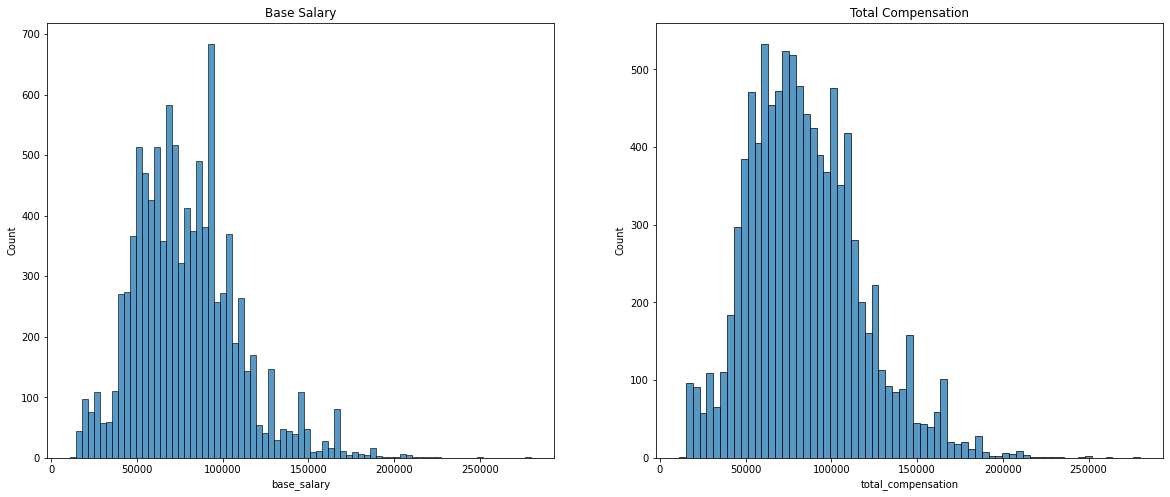

In [318]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(data=df, x='base_salary', ax=axes[0])
axes[0].set_title('Base Salary')

sns.histplot(data=df, x='total_compensation', ax=axes[1])
axes[1].set_title('Total Compensation')

plt.show()

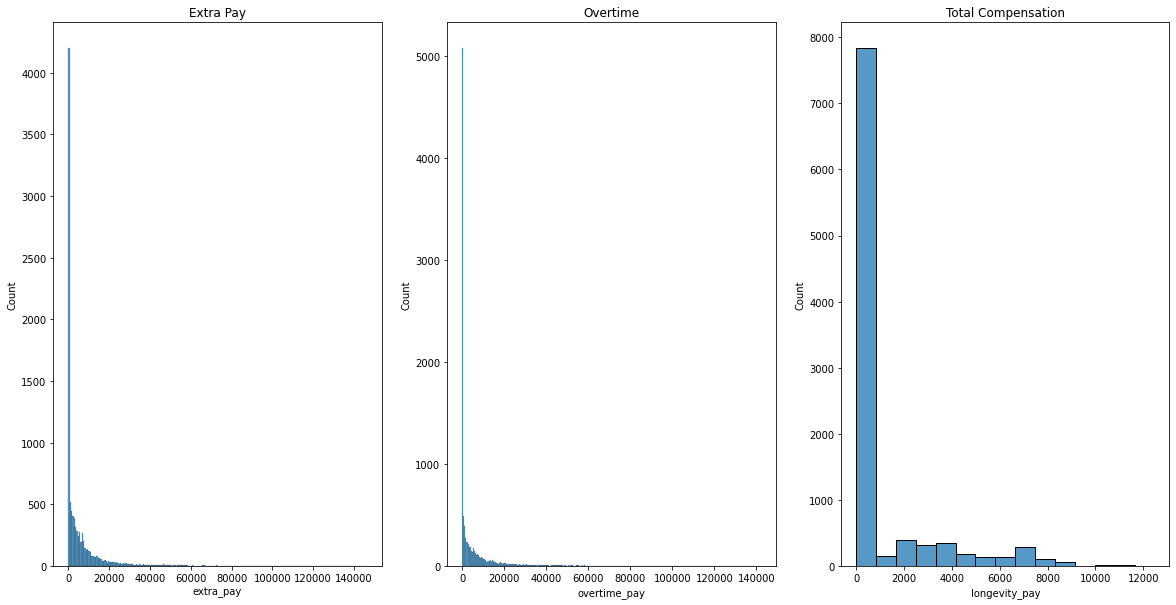

In [319]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

sns.histplot(data=df, x='extra_pay', ax=axes[0])
axes[0].set_title('Extra Pay')

sns.histplot(data=df, x='overtime_pay', ax=axes[1])
axes[1].set_title('Overtime')

sns.histplot(data=df, x='longevity_pay', ax=axes[2])
axes[2].set_title('Total Compensation')


plt.show()

We see from the plots abovee that it is very common for people not to receive any sort of pay beyond their base compensation. This is especially the case for longevity pay, which iis unsurprising.

## Bivariate Analysis

<AxesSubplot:>

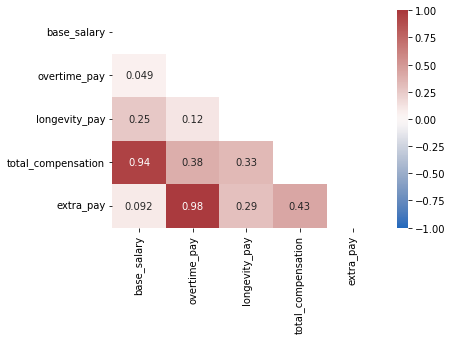

In [320]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1, cmap='vlag')

Above we can see that there are strong correlations involving our engineered features, between total_compensation and base_salary and extra_pay and overtime_pay. In addition to the linear relationship it suggests by definition, this also suggests that total_compensation is largely determined by base_salary and extra_pay is largely determined by overtime_pay. The former is a bit obvious - one expects wages and salaries to contribute more to compensation than longevity pay and overtime in most cases. The latter is not surprising either. It is a safe assumption that longevity pay contributes less to extra pay than overtime, while this is not completely obvious.

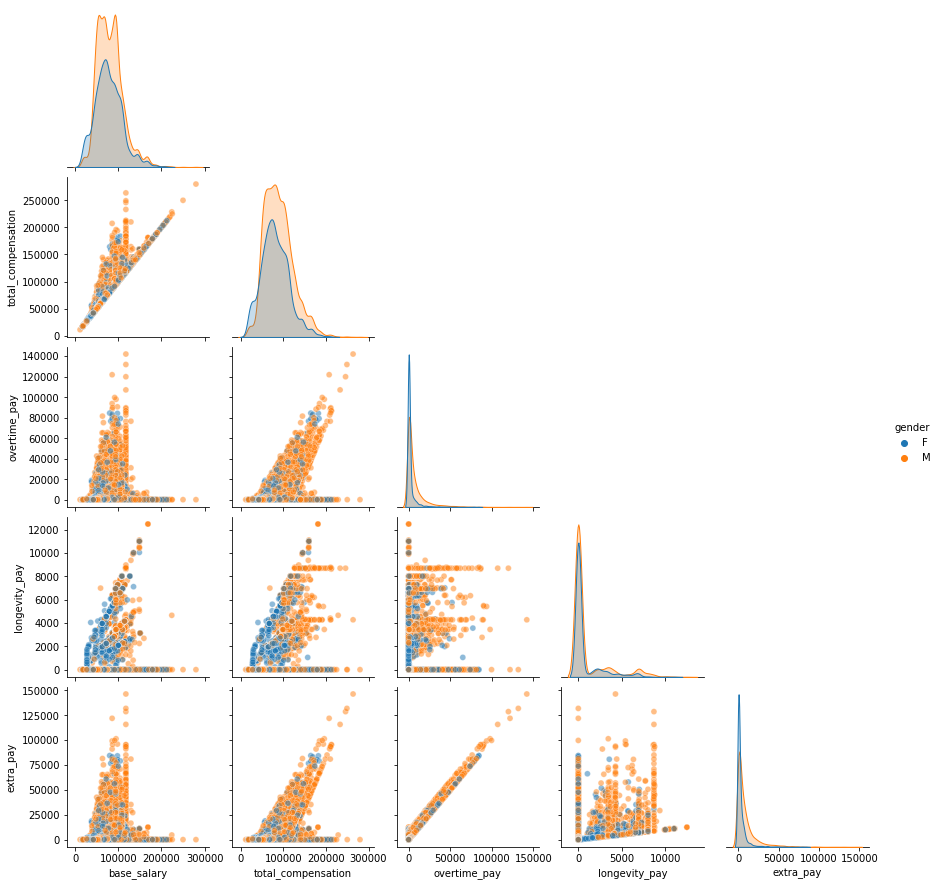

In [321]:
sns.pairplot(df[numerical+['gender']], corner=True, hue='gender', plot_kws={'alpha':0.5})
plt.show()

From the plot above, we can confirm the correlations found by looking at correlation coefficients. The engineered features, extra_pay and total_compensation will be dropped and not used to train the model. 

It is not entirely obvious from the graphs that within each feature, the feature is drawn from a different distribution for each sex. However, women generally do seem to receive less compensation than men.

### Testing Means
Above, it is unclear if the means of gender disaggregated distributions are different. That is tested below.

In [322]:
# Mean of each numereical feature by gender
df[numerical+['gender']].groupby('gender').mean()

,base_salary,total_compensation,overtime_pay,longevity_pay,extra_pay
gender,,,,,
F,76763.832068,79727.283388,2224.741322,738.709998,2963.451320
M,80171.365625,88468.184031,7244.343554,1052.474853,8296.818406


Above is a table showing the mean for each feature broken down by gender. Without testing, it is safe to assert that the features associated with extra pay have a large gender discrepancy. However, significance of the difference of means for all features is tested below with a t-test. Note that the sample size is large enough that the non-normality of the data iis not concerning.

In [323]:
from scipy.stats import ttest_ind
alpha = 0.05
for feature in numerical:
    t, p = ttest_ind(df[df['gender'] == 'M'][feature], df[df['gender'] == 'F'][feature])
    if p < alpha:
        print(f'The mean values of {feature} for men and women are not equal.')
    else:
        print(f'The mean values of {feature} for men and women are equal.')

The mean values of base_salary for men and women are not equal.
The mean values of total_compensation for men and women are not equal.
The mean values of overtime_pay for men and women are not equal.
The mean values of longevity_pay for men and women are not equal.
The mean values of extra_pay for men and women are not equal.


We can see above that the numerical features all have different means for men and women.

## Categorical Variables

## Gender
Gender is the target variable. The representation of the variable is important as sufficiently. imbalanced target classes will affect model performance.

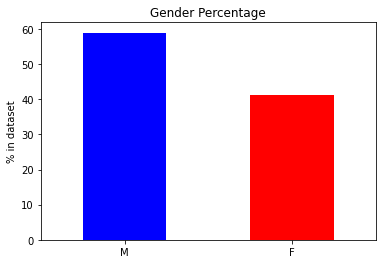

In [324]:
gender_counts = df['gender'].value_counts()/df.shape[0]*100
gender_counts.plot.bar(rot=0, color=['blue', 'red'])
plt.title('Gender Percentage')
plt.ylabel('% in dataset')
plt.show()

The class representation is split about 60/40 in favor of males. This is imbalanced but not so much so that it will necessarily be an issue.

### Departments

In [325]:
num_departments = df['department_name'].nunique()
print(f'There are {num_departments} unique departments.')

There are 40 unique departments.


This is a fair number of departments, each of which could be a unique feature. To aid training, it would be useful to determine if any of these departments are of minimal use and can be discarded.

In [326]:
# Get percentage of men in each department and the number of employees per department
department_gender_ratios = []
dept_name = []
employees = []
for dept in df['department_name'].unique():

    # Calculate the ratio of male to females
    males = df[(df['department_name'] == dept) & (df['gender'] == 'M')]['gender'].count()
    females = df[(df['department_name'] == dept) & (df['gender'] == 'F')]['gender'].count()
    gender_ratio = males/(males+females)

    department_gender_ratios.append(gender_ratio)
    employees.append(males+females)

    dept_name.append(dept)

gender_ratio_dict = {'department_name':dept_name, 'gender_ratio':department_gender_ratios, 'employees':employees}
df_ratios = pd.DataFrame.from_dict(gender_ratio_dict)

In [327]:
df_ratios.describe()

,gender_ratio,employees
count,40.000000,40.00000
mean,0.468323,248.95000
std,0.230357,477.89753
min,0.000000,2.00000
25%,0.337838,13.25000
50%,0.452709,63.50000
75%,0.625034,173.25000
max,0.918262,1940.00000


#### Number of Employees By Departments

<AxesSubplot:xlabel='employees', ylabel='Count'>

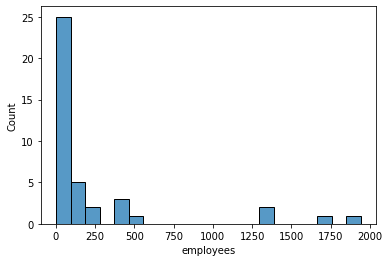

In [328]:
sns.histplot(data=df_ratios, x='employees')

In [329]:
print('Below are the departments with a number of employees above the third quartiile:')
df_ratios[df_ratios['employees'] > np.quantile(df_ratios['employees'], q=0.75)].sort_values('employees', ascending=False)

Below are the departments with a number of employees above the third quartiile:


,department_name,gender_ratio,employees
35,Department of Police,0.638144,1940
19,Department of Health and Human Services,0.156286,1734
17,Fire and Rescue Services,0.918262,1358
12,Department of Transportation,0.804989,1323
7,Correction and Rehabilitation,0.624762,525
0,Alcohol Beverage Services,0.794521,438
10,Department of General Services,0.841346,416
22,Department of Public Libraries,0.223650,389
13,Department of Permitting Services,0.713656,227
38,Sheriff's Office,0.728571,210


In [330]:
print('Below are the departments with a number of employees below the first quartiile:')
df_ratios[df_ratios['employees'] < np.quantile(df_ratios['employees'], q=0.25)].sort_values('employees')

Below are the departments with a number of employees below the first quartiile:


,department_name,gender_ratio,employees
15,Ethics Commission,0.500000,2
23,Merit System Protection Board Department,0.500000,2
1,Board of Appeals Department,0.000000,3
33,Office of Racial Equity and Social Justice,0.000000,3
21,Office of Intergovernmental Relations Department,0.000000,5
39,Office of Zoning and Administrative Hearings,0.400000,5
31,Office of Labor Relations,0.857143,7
20,Office of Human Rights,0.555556,9
25,Office of Agriculture,0.600000,10
29,Office of the Inspector General,0.363636,11


Generally speaking, decision tree makes binary decisions with respect to features, with the goal of increasing the purity with respect to the target class, gender, of the resulting two sides of the split. In the case of features that are binary classes, like our encoded departments will be, this only helps the model to the extent these features are relatively balanced.

Suppose we train a decision tree on all of the data, and the first split the decision tree makes is about a one hot encoded Board of Appeals feature. As a result the data is now split into two buckets. One consists of 3 people, all women. But this is still not a useful split for the tree to make because the other bucket consists of thousands of samples, and has a gender balance all but equivalent to the balance of all of the original data before the split. We would prefer that the tree never even consider splitting about this feature, and for that reason, the small departments above are dropped.

In [331]:
features_to_drop = df_ratios[df_ratios['employees'] < np.quantile(df_ratios['employees'], q=0.25)]['department_name'].values

#### Check Gender Balance Distribution within Departments
Knowing a person works in a department with 50% men provides no information about that person's gender. On the other hand, knowing a person belongs to a department with 100% or 0% men completely establishes their gender.  Below, the gender ratios within departments are examined, and departments that have a perfect 50/50 split between men and women.

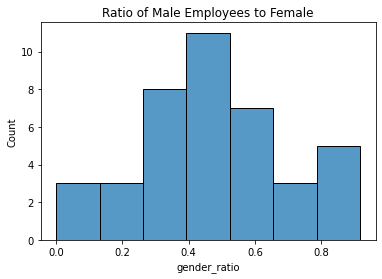

In [332]:
sns.histplot(data=df_ratios, x='gender_ratio')
plt.title('Ratio of Male Employees to Female')
plt.show()


In [333]:
print('Below are the departments with gender ratios above the 3rd quartile, other than all-male departments, along with the number of employees per quartile.')
df_ratios[(df_ratios['gender_ratio'] > np.quantile(df_ratios['gender_ratio'], q=0.75)) & (df_ratios['gender_ratio'] != 1)].sort_values('gender_ratio', ascending=False)

Below are the departments with gender ratios above the 3rd quartile, other than all-male departments, along with the number of employees per quartile.


,department_name,gender_ratio,employees
17,Fire and Rescue Services,0.918262,1358
31,Office of Labor Relations,0.857143,7
10,Department of General Services,0.841346,416
12,Department of Transportation,0.804989,1323
0,Alcohol Beverage Services,0.794521,438
38,Sheriff's Office,0.728571,210
13,Department of Permitting Services,0.713656,227
5,Community Engagement Cluster,0.674699,83
35,Department of Police,0.638144,1940
14,Department of Technology Services,0.625850,147


Above, we can see that departments are generally skewed towards employing more men, and the gender imbalance is often substantial. A rational explanation for this might be that such departments employ relatively few people. For example, a department employing only 3 people will never have the same number of employees identified as male and female, and the imbalance presented as a percentage will always look severe. However, from the table above, we see this is not the case. With the exception of the Office of Labor Relations, the departments with gender imbalances above the third quartile also havee numbers of employees above the third quartile.

In [334]:
print('Below are the departments with gender ratios below the 1st quartile, other than all-femal departments along with the number of employees per quartile.')
df_ratios[(df_ratios['gender_ratio'] < np.quantile(df_ratios['gender_ratio'], q=0.25)) & (df_ratios['gender_ratio'] != 0)].sort_values('gender_ratio', ascending=False)

Below are the departments with gender ratios below the 1st quartile, other than all-femal departments along with the number of employees per quartile.


,department_name,gender_ratio,employees
3,County Attorney's Office,0.297297,74
26,Office of Animal Services,0.291667,72
16,Department of Finance,0.285714,119
28,Office of Human Resources,0.275862,58
2,Board of Elections,0.241379,29
22,Department of Public Libraries,0.223650,389
19,Department of Health and Human Services,0.156286,1734


Above, we see that there are only 3 departments with 50/50 representation of men and women. All three are small departments, which is unsurprising. All three will be removed. 

In [335]:
features_to_drop = np.concatenate([features_to_drop, df_ratios[df_ratios['gender_ratio'] == .5]['department_name'].values])

### Divisions

In [336]:
num_divisions = df['division'].nunique()
print(f'There are {num_divisions} unique divisions.')

There are 605 unique divisions.


This is a very large number of divisions, given that each could be a unique feature. Including them all could make the training process much harder. Further, taken as a whole, they must contain the same information about gender distributions as the deparment, since every department consists of divisiions, albeit this information is split up in a diffent manner.

In [337]:
# Get percentage of men in each division and the number of employees per division
division_gender_ratios = []
division_name = []
employees = []
for division in df['division'].unique():
    # Calculate the ratio of male to females
    males = df[(df['division'] == division) & (df['gender'] == 'M')]['gender'].count()
    females = df[(df['division'] == division) & (df['gender'] == 'F')]['gender'].count()
    gender_ratio = males/(males+females)

    division_gender_ratios.append(gender_ratio)
    employees.append(males+females)

    division_name.append(division)

gender_ratio_dict = {'division':division_name, 'gender_ratio':division_gender_ratios, 'employees':employees}
df_division_ratios = pd.DataFrame.from_dict(gender_ratio_dict)

In [338]:
df_division_ratios.describe()

,gender_ratio,employees
count,605.000000,605.000000
mean,0.566116,16.459504
std,0.352437,36.760102
min,0.000000,1.000000
25%,0.250000,3.000000
50%,0.625000,7.000000
75%,0.909091,14.000000
max,1.000000,361.000000


We can see from the table above that most of the divisions have very small numbers of employees, meaning that they will not be very useful to the model. The divisions are so small, that I would not consider putting most in the model at all and focus the rest of my attention on only those with at least 100 employees.

In [339]:
df_division_ratios[df_division_ratios['employees'] > 100]

,division,gender_ratio,employees
145,Fleet Management Fleet Services,1.000000,110
165,Highway Services,0.925439,228
179,Transit Gaithersburg Ride On,0.798834,343
185,Transit Silver Spring Ride On,0.846154,299
186,Transit Nicholson Ride On,0.741935,155
382,Behavioral Health and Crisis Services Division,0.218182,220
384,Office of Eligibility and Support Services,0.209877,243
385,Aging & Disability Services Division,0.114458,166
387,Public Health Services Division,0.187500,208
390,School Health Services,0.038781,361


There are a fair number of features with over 100 employees, and these will be used to develop the model.

In [340]:
features_to_drop = np.concatenate([features_to_drop, df_division_ratios[df_division_ratios['employees'] < 100]['division'].values])

### Pay Grades

In [341]:
num_pay_grades = df['pay_grade'].nunique()
print(f'There are {num_pay_grades} unique pay grades.')

There are 73 unique pay grades.


This is again a decently large number of pay grades, and it would be good to eliminate some.

In [342]:
print('Below are the unique pay grades:')
df['pay_grade'].unique()

Below are the unique pay grades:


array(['18', '16', 'M2', '21', '25', '15', '10', '12', '17', '14', '13',
       '26', '20', 'M3', '19', '9', '28', '0', 'M1', '23', '22', '32',
       '5', '24', '27', 'C5', 'C1', 'C4', 'C2', 'C6', 'C3', '11', '30',
       '8', '7', '34', '40', '29', 'B2', 'B6', 'F4', 'B1', 'F3', 'B3',
       'F2', 'B4', 'B2P', 'F1', 'MD4', 'MD3', 'MD2', '39', '33', '38',
       '31', 'P4', 'A1', 'P5', 'A2', 'A3', 'P4P', 'P3', 'P2', 'P1', 'D1',
       'G4', 'D2', 'D3', 'D4', 'G3', 'G2', 'G1', '35'], dtype=object)

Above we can see the unique pay grades. These can be broken down into smaller categories
* Numbers: These are the general pay grades
* Beginning with M: management level pay grades
* Beginning with C: correectional officers, correctional supervisors, etc.
* Beginning with B: certain fire department pay grades
* Beginning with F: certain other fire department pay grades
* Beginning with MD: certain Department of Health and Human Services pay grades
* Beginning with P: police department pay grades
* Beginning with D: certain Sherriff's Office pay grades
* Beginning with G: certain other Sherriff's Office pay grades

These are then numbered to determine compensation levels. See, e.g. the slide deck [here](https://www.montgomerycountymd.gov/HR/Resources/Files/Classification/Compensation%20Documents/PMR%202020%2004072020.pdf), For grades beginning with letters, a higher number means lower compensation. But for grades that are just numbers, lower letters mean lower compensation.

In [343]:
# Get percentage of men in each pay grade and the number of employees per department
pay_grade_gender_ratios = []
pay_grade_name = []
employees = []
for pay_grade in df['pay_grade'].unique():
    # Calculate the ratio of male to females
    males = df[(df['pay_grade'] == pay_grade) & (df['gender'] == 'M')]['gender'].count()
    females = df[(df['pay_grade'] == pay_grade) & (df['gender'] == 'F')]['gender'].count()
    gender_ratio = males/(males+females)

    pay_grade_gender_ratios.append(gender_ratio)
    employees.append(males+females)

    pay_grade_name.append(pay_grade)

gender_ratio_dict = {'pay_grade':pay_grade_name, 'gender_ratio':pay_grade_gender_ratios, 'employees':employees}
df_pay_grade_ratios = pd.DataFrame.from_dict(gender_ratio_dict)

In [344]:
df_pay_grade_ratios.describe()

,gender_ratio,employees
count,73.000000,73.000000
mean,0.688060,136.410959
std,0.259135,202.062479
min,0.000000,1.000000
25%,0.500000,7.000000
50%,0.761468,38.000000
75%,0.894737,196.000000
max,1.000000,1125.000000


#### Number of Employees by Pay Grade

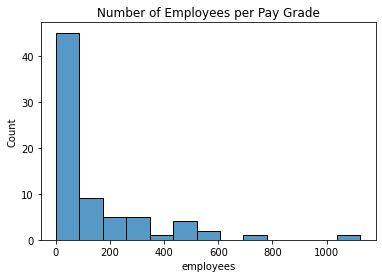

In [345]:
sns.histplot(data=df_pay_grade_ratios, x='employees')
plt.title('Number of Employees per Pay Grade')
plt.show()

Immediately, we can tell that most pay grades are small, while a m nority are fairly large, representing several hunred employees.

In [346]:
print('Below are the pay grades with a number of employees above the third quartiile:')
df_pay_grade_ratios[df_pay_grade_ratios['employees'] > np.quantile(df_pay_grade_ratios['employees'], q=0.75)]

Below are the pay grades with a number of employees above the third quartiile:


,pay_grade,gender_ratio,employees
0,18,0.404494,445
1,16,0.252747,455
3,21,0.433145,531
4,25,0.403599,389
5,15,0.657778,1125
6,10,0.322034,236
7,12,0.682243,214
9,14,0.761468,218
10,13,0.279693,261
12,20,0.372611,314


With the exception of M3, these pay grades are either those that are not limited to particular departments or those from large departments, which makes sense. With the exception of M3, which has a nearly equal gender balance, they are also skewed towards mostly men or mostly women, some quite substantially.

In [347]:
print('Below are some of the pay grades with a number of employees below the median:')
grade_below_median = df_pay_grade_ratios[df_pay_grade_ratios['employees'] < np.quantile(df_pay_grade_ratios['employees'], q=0.5)]
grade_below_median.head(15)

Below are some of the pay grades with a number of employees below the median:


,pay_grade,gender_ratio,employees
15,9,0.972222,36
18,M1,0.538462,26
22,5,0.764706,17
24,27,0.555556,36
26,C1,0.727273,22
28,C2,0.750000,4
30,C3,0.846154,26
31,11,0.541667,24
32,30,0.400000,15
34,7,1.000000,2


The pay grades above have few members, so they will be dropped.

#### Check Gender Balance Distribution within Pay Grades


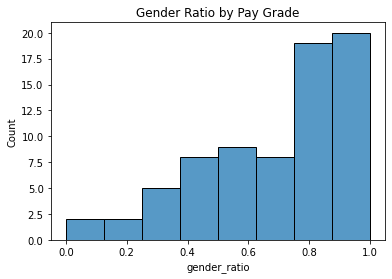

In [348]:
sns.histplot(data=df_pay_grade_ratios, x='gender_ratio')
plt.title('Gender Ratio by Pay Grade')
plt.show()


From the above, it is clear that there are lots of pay grades that are skewed heavily with respect to gender, specifically, they are mostly male. However, further analysis is required to determine if each pay grade contains enough employees to be worth keeping in the model.

In [349]:
print('Below are the pay grades with a gender ratio above the third quartile:')
df_pay_grade_ratios[df_pay_grade_ratios['gender_ratio'] > np.quantile(df_pay_grade_ratios['gender_ratio'], q=0.75)]

Below are the pay grades with a gender ratio above the third quartile:


,pay_grade,gender_ratio,employees
15,9,0.972222,36
34,7,1.000000,2
35,34,1.000000,3
38,B2,0.926667,150
39,B6,1.000000,3
40,F4,0.958716,218
41,B1,0.959677,124
42,F3,0.950783,447
43,B3,0.920000,25
44,F2,0.916058,274


Many of these are actually quite small. Note that those will be removed. But others reepresent a substantial number of employees and should be kept in the model.

In [350]:
print('Below are some of the pay grades with gender ratio below the median:')
gender_ratio_below_median = df_pay_grade_ratios[df_pay_grade_ratios['gender_ratio'] < np.quantile(df_pay_grade_ratios['gender_ratio'], q=0.25)]
gender_ratio_below_median

Below are some of the pay grades with gender ratio below the median:


,pay_grade,gender_ratio,employees
0,18,0.404494,445
1,16,0.252747,455
3,21,0.433145,531
4,25,0.403599,389
6,10,0.322034,236
8,17,0.496894,161
10,13,0.279693,261
12,20,0.372611,314
13,M3,0.496403,278
19,23,0.410042,478


A substantial number of these represent a good number of workers. However, M3 has nearly 50% women. For this reason, I will manually drop all pay grades with < 49% women. Other pay grades that will be dropped are those with fewer than the median number of employees or those with a gender ratio under the third quartile.

In [351]:
employee_median = np.quantile(df_pay_grade_ratios['employees'], q=0.5)

gender_ratio_1q = np.quantile(df_pay_grade_ratios['gender_ratio'], q=0.25)
gender_ratio_3q = np.quantile(df_pay_grade_ratios['gender_ratio'], q=0.75)

bad_pay_grades = df_pay_grade_ratios[(df_pay_grade_ratios['employees'] <= employee_median) & ((df_pay_grade_ratios['gender_ratio'] >= .49) | (df_pay_grade_ratios['gender_ratio'] <= gender_ratio_3q))]
features_to_drop = np.concatenate([features_to_drop, bad_pay_grades['pay_grade'].values])

# Encoding Categorical Variables
Each division and department is one hot encoded into a different feature.

In [352]:
depts = pd.get_dummies(data=df['department_name'])
divisions = pd.get_dummies(data=df['division'])
pay_grade = pd.get_dummies(data=df['pay_grade'])

df = pd.concat([df[numerical+['gender']], depts, divisions, pay_grade], axis=1)

## Drop  Features
Certain divisions and departments are dropped, as discussed above.

In [353]:
df = df[[feature for feature in df.columns if feature not in features_to_drop]]
print(f'Dropped {len(features_to_drop)} features.')

Dropped 637 features.


# Train Classifier

## Cross Validation

In [354]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df[[feature for feature in df.columns if feature != 'gender']],
                                                     df['gender'].astype('category').cat.codes,
                                                     stratify=df['gender'].astype('category').cat.codes, random_state=123)

In [364]:

from sklearn.model_selection import GridSearchCV
def do_cv(x_train, y_train):
    '''
    Performs 5-fold cross validation while searching randomly through parameters space.
    '''
    clf_xgb = XGBClassifier(random_state=1234)
    param_dist = {'n_estimators': np.linspace(150, 500, dtype=int),
                'learning_rate': np.logspace(-5, 0, base=10, num=100),
                # Subsample ratio for training instances
                'subsample': np.logspace(-5, 0, base=10, num=100),
                'max_depth': [3, 4, 5],
                # Subsample ratio for columns when constructing trees
                'colsample_bytree': np.logspace(-5, 0, base=10, num=100),
                'min_child_weight': [1, 2, 3]
                }
    clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 500, 
                            scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = 3, random_state=1234)

    # clf = GridSearchCV(clf_xgb, param_grid=param_dist,
    #                         scoring = 'accuracy', error_score = 0, verbose = 3, n_jobs = 3)

    clf.fit(x_train, y_train)
    return clf.best_estimator_


xg = do_cv(x_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [365]:
val_size = int(x_train.shape[0]*0.8)
x_train_full, y_train_full = x_train, y_train

x_train, y_train = x_train_full[:val_size], y_train_full[:val_size]
x_val, y_val = x_train_full[val_size:], y_train_full[val_size:]

eval_set = [(x_train, y_train), (x_val, y_val)]
xg.fit(x_train, y_train, eval_metric=['logloss', 'error'], eval_set=eval_set, verbose=False)

results = xg.evals_result()

c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


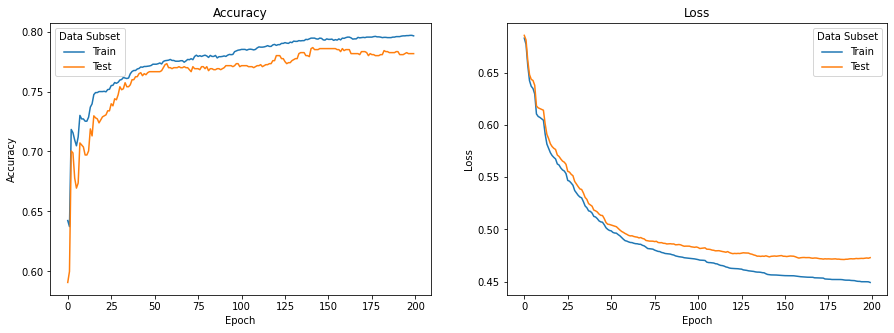

In [366]:
train_acc = [1-err for err in results['validation_0']['error']]
test_acc = [1-err for err in results['validation_1']['error']]

train_ce =results['validation_0']['logloss']
test_ce = results['validation_1']['logloss']

epochs = range(len(test_acc))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(x=epochs, y=train_acc, ax=axes[0])
sns.lineplot(x=epochs, y=test_acc, ax=axes[0])
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(title='Data Subset', loc='upper left', labels=['Train', 'Test'])


sns.lineplot(x=epochs, y=train_ce, ax=axes[1])
sns.lineplot(x=epochs, y=test_ce, ax=axes[1])
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(title='Data Subset', loc='upper right', labels=['Train', 'Test'])


plt.show()


From the training process above, we can seee that the model's training plateau's very quickly in the training process, certainly by at least epoch 150. From that point onwards, the model continues to fit to the training set, while the test set accuracy eventually decreases and the loss plateaus. to avoid this, the model is overtrained and stopped at the 150th epoch.

In [367]:
# Train with early stopping
xg.fit(x_train, y_train, early_stopping_rounds=150, eval_metric=['logloss', 'error'], eval_set=eval_set, verbose=0)

c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.0774263682681127, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.12328467394420659,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, ...)

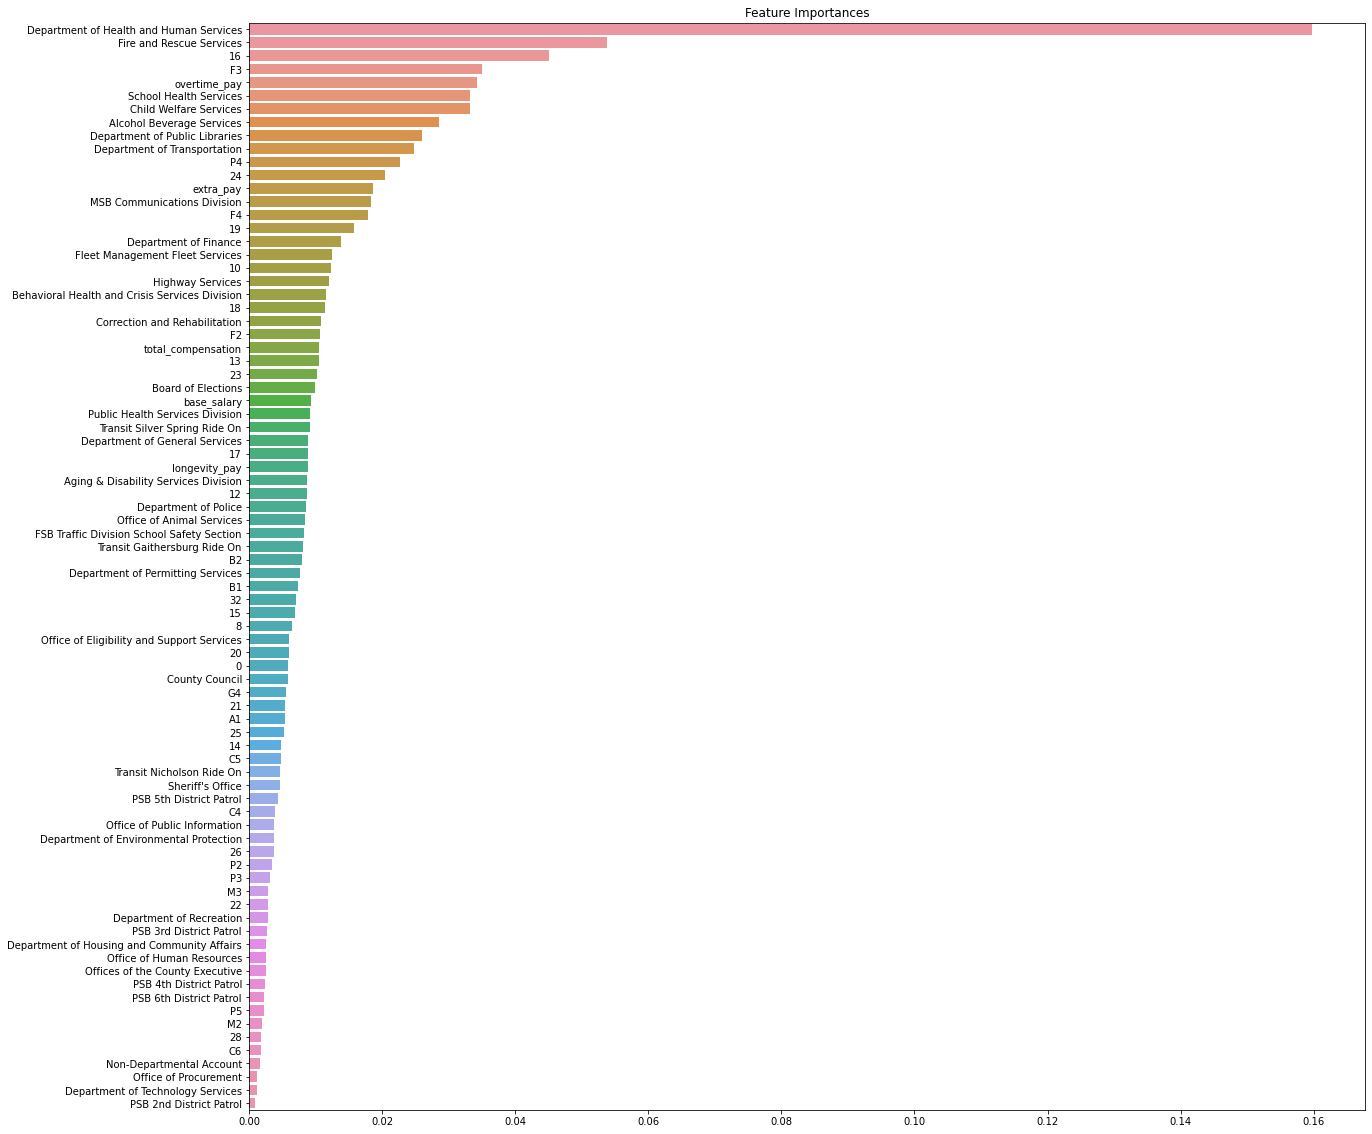

In [368]:
feat_imps = sorted([(xg.feature_names_in_[i], feat_importance) for i, feat_importance in enumerate(xg.feature_importances_) if feat_importance > 0], key=lambda x: x[1], reverse=True)
feature_names, importances = zip(*feat_imps)

plt.figure(figsize=(20, 20))
sns.barplot(x=list(importances), y=list(feature_names))
plt.title('Feature Importances')
plt.show()

In [369]:
print(f'The model found the following features useless:')
for feat in df.columns:
    if feat not in feature_names:
        print(feat)

The model found the following features useless:
gender
Office of Emergency Management and Homeland Security


The model finds most of our non-target features to be at least minimally important. Further, many of the large, gender-imbalanced departments and some pay grades representing the fire department, which has a high level of gender imbalance, are given relatively high importances.

# Evaluation
The model is evaluated using four metrics. 
* Accuracy: the percentage of samples classified correctly.
* Precision: for a class, of the samples classified as the class, what percentage was classified correctly?
* Recall: for a class, what percentage of class members were correctly classified as the class?
* f1: a harmonic mean  of precision and recall

In [370]:
y_pred = xg.predict(x_test)
print(classification_report(y_pred, y_test, target_names=['Female', 'Male']))

              precision    recall  f1-score   support

      Female       0.64      0.77      0.70       847
        Male       0.87      0.78      0.82      1643

    accuracy                           0.78      2490
   macro avg       0.76      0.78      0.76      2490
weighted avg       0.79      0.78      0.78      2490



The model classified 78% of samples correctly, but performance differed greatly between the classes. The model received an f1 score of only 0.70 on Female samples but performed substantially better on Male samples, with an f1 score of 0.82

When the model classified samples as female, it was right only 64% of the same, but it correctly identified 77% of female samples. When the model classified samples as male, it was right 87% of the time, but it only identified 78% of males.

# Conclusion
The model performs fairly well, with an accuracy of 78%, but its pereformance varies substantially between classes.